### I Подключение библиотек

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

# Подключаем необходимые библиотеки для машинного обучения
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

________________________________________________________________________________________________________________________________

### II Загружаем данные

In [2]:
item = 'nassCDS' # Выбираем из поля Item нашего датасета
package = 'DAAG' # Выбираем из поля Package нашего датасета

dfnew = sm.datasets.get_rdataset(item, package , cache=True).data
dfnew.head()

,dvcat,weight,dead,airbag,seatbelt,frontal,sex,ageOFocc,yearacc,yearVeh,abcat,occRole,deploy,injSeverity,caseid
0,25-39,25.069,alive,none,belted,1,f,26,1997,1990.0,unavail,driver,0,3.0,2:3:1
1,10-24,25.069,alive,airbag,belted,1,f,72,1997,1995.0,deploy,driver,1,1.0,2:3:2
2,10-24,32.379,alive,none,none,1,f,69,1997,1988.0,unavail,driver,0,4.0,2:5:1
3,25-39,495.444,alive,airbag,belted,1,f,53,1997,1995.0,deploy,driver,1,1.0,2:10:1
4,25-39,25.069,alive,none,belted,1,f,32,1997,1988.0,unavail,driver,0,3.0,2:11:1


________________________________________________________________________________________________________________________________

### III Изучаем датасет

In [3]:
dfnew.shape

(26217, 15)

In [4]:
dfnew['dvcat'].unique()     # Таким образом проссматриваю уникальные значения всех столбцов поочереди

array(['25-39', '10-24', '40-54', '55+', '1-9km/h'], dtype=object)

In [5]:
dfnew['ageOFocc'].describe()     # Таким образом проссматриваю небольшую статистику по столбцам

count    26217.000000
mean        37.206202
std         17.909317
min         16.000000
25%         22.000000
50%         33.000000
75%         48.000000
max         97.000000
Name: ageOFocc, dtype: float64

________________________________________________________________________________________________________________________________

### IV Проведем очистку данных от пропусков, выбросов и некорректных значений

In [6]:
# Проверяем, есть ли в датасете дубликаты строк

dfnew[dfnew.duplicated()]     # Дубликатов нет

,dvcat,weight,dead,airbag,seatbelt,frontal,sex,ageOFocc,yearacc,yearVeh,abcat,occRole,deploy,injSeverity,caseid


In [7]:
# Поссмотрим пропуски
dfnew.isna().sum()

dvcat            0
weight           0
dead             0
airbag           0
seatbelt         0
frontal          0
sex              0
ageOFocc         0
yearacc          0
yearVeh          1
abcat            0
occRole          0
deploy           0
injSeverity    153
caseid           0
dtype: int64

In [8]:
# Убираем строки с пропусками
dfnew1 = dfnew[(dfnew['yearVeh']>1)&(dfnew['injSeverity']>=0)]
dfnew1.shape

(26063, 15)

In [9]:
# Выбросы будем искать во Возрасту человека, так как это единственное поле с множеством значений
# Возьмем метод через IQR

q1 = dfnew1['ageOFocc'].quantile(0.25)
q3 = dfnew1['ageOFocc'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr
print(f"Выбросами будут считаться все возрасты, значения которых находится за пределами интервала [{lower_bound}, {upper_bound}]")

Выбросами будут считаться все возрасты, значения которых находится за пределами интервала [-17.0, 87.0]


In [10]:
# Формируем новый датасет без выбросов и пропусков
df = dfnew1[((dfnew1['ageOFocc'] >= lower_bound) & (dfnew1['ageOFocc'] <= upper_bound)) | (dfnew1['ageOFocc'].isna())]
df.shape

(25957, 15)

________________________________________________________________________________________________________________________________

### V Протестируем распределение числовой переменной на соответствие нормальному. Построим QQ-plot и гистограмму.

In [11]:
# Используем тест Колмогорова-Смирнова на нормальность распределения столбца ВОЗРАСТ
stats.kstest(df['ageOFocc'], stats.norm.cdf)

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=16, statistic_sign=-1)

Нулевая гипотеза - распределение нормальное. В тесте р-значение является очень низким, то есть нулевая гипотеза отвергается, и распределение возрастов людей нельзя считать нормальным.

In [12]:
# Используем тест Андерсона-Дарлинга на нормальность распределения столбца ВОЗРАСТ
stats.anderson(df['ageOFocc'], dist='norm')

AndersonResult(statistic=685.4232967137505, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=37.00674191932812, scale=17.614305184049226)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Нулевая гипотеза - распределение нормальное. Для уровня значимости 0,05 критическое значение составляет 0,787, а наблюдаемое значение 685.42. Наблюдаемая статистика гораздо выше критического значения, то есть нулевая гипотеза отвергается, и распределение возрастов людей нельзя считать нормальным.

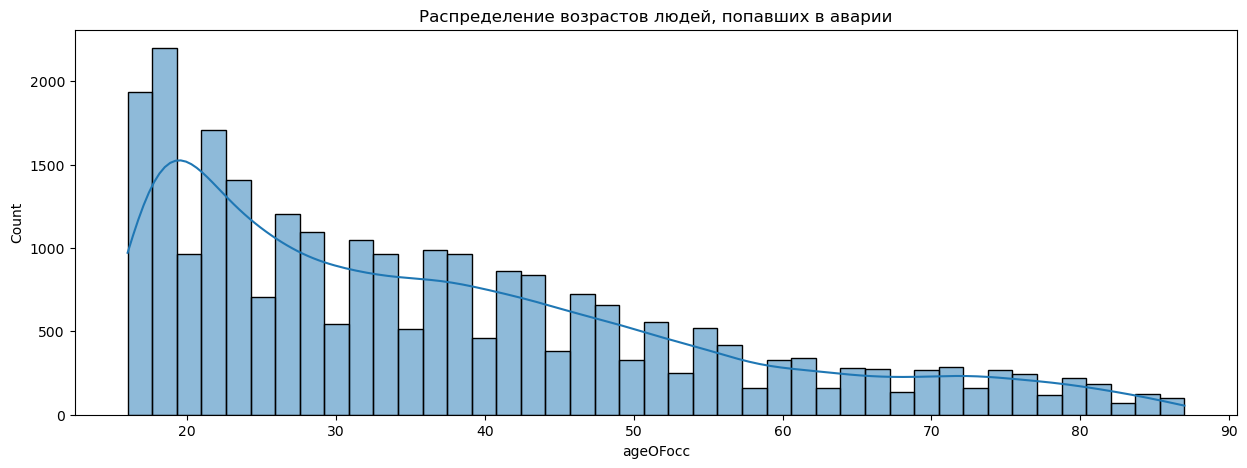

In [13]:
# Построим гистограмму распределения ВОЗРАСТОВ людей, попавших в аварии
plt.figure(figsize = (15,5))
plt.title('Распределение возрастов людей, попавших в аварии')
sns.histplot(df['ageOFocc'], kde = True)
plt.show()

По гистограмме видно, что распределение не нормальное (с виду не "колокольчик")

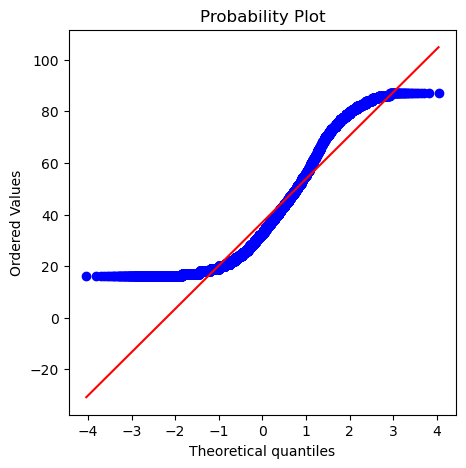

In [14]:
# Построим QQ-плот для ВОЗРАСТОВ людей, попавших в аварии
fig, ax  = plt.subplots(1, figsize = (5,5))
plt.title('QQ-плот для ВОЗРАСТОВ людей, попавших в аварии')
stats.probplot(df['ageOFocc'], dist="norm", plot = ax)
plt.show()

По графику видно, что в целом нормальное распределение отсутствует. Нормально распределены только некоторые серединные значения, начало и конец графика сильно отличаются от нормального распределения.
##### С ПРАКТИЧЕСКОЙ ТОЧКИ ЗРЕНИЯ: Основная масса людей, попавших в аварии, это молодые люди. Чем возрасты людей выше, тем меньше количество аварий. Конечно это может быть связано как и со стилем вождения (взрослые ездят поумеренее), так и с тем, что возрастные люди ездят на машинах меньше по времени.
##### ВЫВОД: ЕЗДИТЬ НУЖНО АККУРАТНЕЕ, СТАТИСТИКА ГОВОРИТ, ЧТО ЛИХАЧЕСТВО ДО ДОБРА НЕ ДОВОДИТ (относится к молодым водителям, любящим полихачить)!!!

________________________________________________________________________________________________________________________________

### VI Сформулируем на базе переменных три вида гипотез. Проведем тесты гипотез и сделаем выводы.

#### 1) Выберем две категориальные переменные и сформулируем гипотезу об их взаимосвязи
Взаимосвязь двух категориальных переменных тестируется путем построения таблицы сопряженности и использования теста Пирсона (хи-квадрат). Визуализация лучше всего делается тепловой картой.

In [15]:
# Сформируем датасеты со столбцами Смертность и Наличие ремней безопасности
df_dead = df['dead']
df_gender = df['seatbelt']

# Построим таблицу сопряженности
df_dead_gender = pd.crosstab(df_dead, df_gender)
df_dead_gender

seatbelt,belted,none
dead,,
alive,17905,6896
dead,486,670


In [16]:
# Используем тест Пирсона (хи-квадрат) для проверки взаимосвязи двух категориальных переменных
stats.chi2_contingency(df_dead_gender)

Chi2ContingencyResult(statistic=484.8084155065377, pvalue=1.9206752312922432e-107, dof=1, expected_freq=array([[17571.95326887,  7229.04673113],
       [  819.04673113,   336.95326887]]))

##### Нулевая гипотеза - между двумя категориальными переменными зависимости нет.
##### р-значение существенно ниже 5%, следовательно, данные противоречат нулевой гипотезе и мы можем ее отвергнуть.
##### Между смертностью в ДТП и наличием ремней безопасности в ТС есть значимая зависимость.
##### С ПРАКТИЧЕСКОЙ ТОЧКИ ЗРЕНИЯ: пристегнутый ремень безопасности снижает получение тяжелых травм, несовместимых с жизнью.
##### ВЫВОД: ВСЕГДА НЕОБХОДИМО ПРИСТЕГИВАТЬСЯ РЕМНЕМ БЕЗОПАСНОСТИ!!!

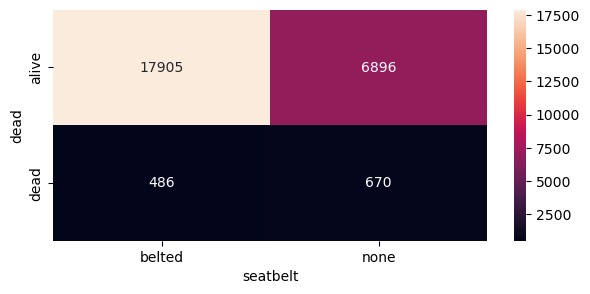

In [17]:
# Визуализируем итоги на тепловой карте
plt.figure(figsize = (7,3))
sns.heatmap(df_dead_gender, annot = True, fmt='.0f')
plt.show()

#### 2) Выберем одну категориальную и одну числовую переменную и сформулируем гипотезу об их взаимосвязи
В случае, если категориальная переменная принимает только два значения, то мы используем Т-тест (тест Манна-Уитни) для сравнения мат ожиданий количественной переменной в двух группах

In [18]:
# Сформируем группу 1 - датасет только с мужчинами водителями
df_M = df[(df['sex'] == 'm')&(df['occRole'] == 'driver')]
df_M.shape

(11450, 15)

In [19]:
# Сформируем группу 2 - датасет только с женщинами водителями
df_F = df[(df['sex'] == 'f')&(df['occRole'] == 'driver')]
df_F.shape

(9018, 15)

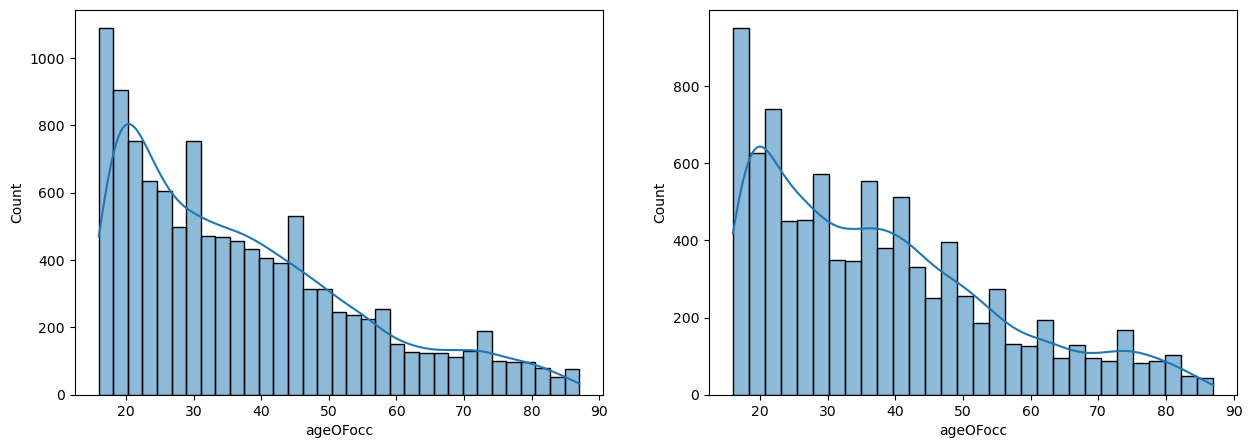

In [20]:
# Нарисуем графики распределения ВОЗРАСТОВ по мужчинам-водителям (слева) и женщинам-водителям (справа)
fig, ax  = plt.subplots(1,2, figsize = (15,5))
sns.histplot(df_M['ageOFocc'], kde = True, ax = ax[0])
sns.histplot(df_F['ageOFocc'], kde = True, ax = ax[1])
plt.show()

In [21]:
# Так как распределение Возраста не является нормальным, то используем Тест Манна-Уитни для тестирования гипотезы о том,
# что средний возраст водителей муского и женского пола, попавших в аварию, совпадает
stats.mannwhitneyu(df_M['ageOFocc'], df_F['ageOFocc'], alternative = 'two-sided')

MannwhitneyuResult(statistic=50867692.5, pvalue=0.06994796653328493)

##### p-значение оказалось выше 5%, то есть нулевая гипотеза не отвергается
##### С ПРАКТИЧЕСКОЙ ТОЧКИ ЗРЕНИЯ: средний возраст водителей муского и женского пола, попавших в аварию, совпадает (примерно одинаковый)
##### ВЫВОД: возраст не является основным фактором, влияющим на вероятность ДТП

#### 3) Выберем две числовые переменные и сформулируем гипотезу об их взаимосвязи

Взаимосвязь двух количественных переменных тестируется либо расчетом коэффициента корреляции, либо построением модели линейной регрессии. Визуализация лучше всего делается точечной диаграммой (scatterplot)

In [22]:
# К сожалению в датасете кроме следующих двух переменных больше нечего брать, по остальным результаты получаются некрасивые и нечитаемые

# Рассчитаем коэфициент корреляции для столбцов возраст человека и Года выпуска ТС
df['ageOFocc'].corr(df['yearVeh'])

0.02044033077853519

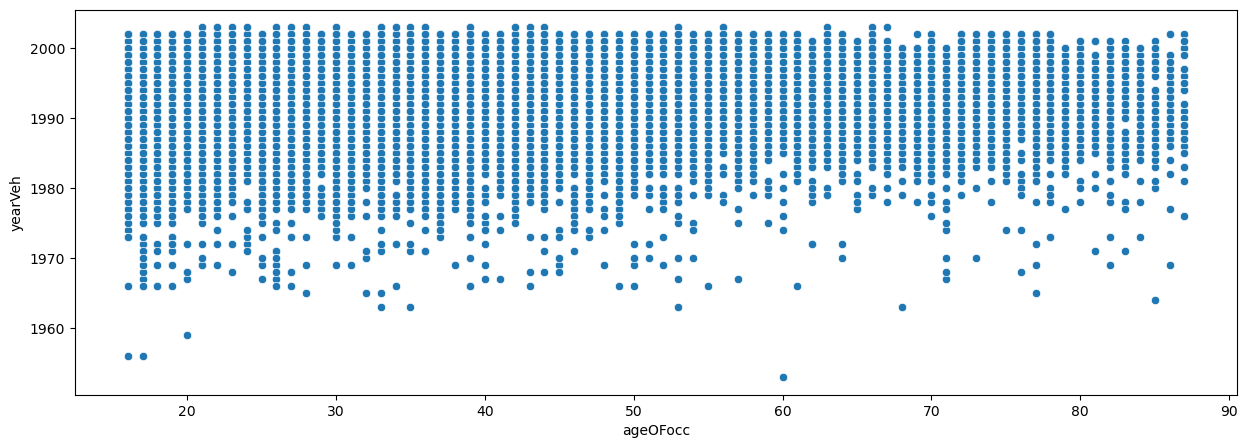

In [23]:
# Построим диаграмму зависимости Возраста человека и Года выпуска ТС
plt.figure(figsize = (15,5))
sns.scatterplot(data = df, x = 'ageOFocc', y = 'yearVeh')
plt.show()

##### Точечная диаграмма показывает, что при увеличении возраста человека прослеживается небольшое увеличение года выпуска ТС. Люди старше примерно 55 лет попадали в аварии в основном на ТС с годом выпуска от 1975 года. Люди младше примерно 55 лет попадали в аварии также и на ТС с годом выпуска до 1975 года.
##### Расчет корреляции показал, что линейная взаимосвязь Возраста человека и Года выпуска ТС крайне минимальна - почти отсутствует (значение до 0,3). Больше похоже на квадратичную зависимость, будто на графике присутствует одна из ветвей параболы.
##### С ПРАКТИЧЕСКОЙ ТОЧКИ ЗРЕНИЯ: линейной взаимосвязи практически нет, но имеет место быть такой факт - так как это данные Америки с 1997 по 2002 гг., то можно предположить, что в это время более молодые люди ездили на ТС более старшего года выпуска вследствие финансового положения, экономики, зарплат, уровня жизни. Соответственно чаще на них попадали в аварии, чем люди постарше.
##### ВЫВОД: У СТАРШЕГО ПОКОЛЕНИЯ В НУЛЕВЫЕ ГОДА В АМЕРИКЕ ФИНАНСОВОЕ ПОЛОЖЕНИЕ БЫЛО ЗНАЧИТЕЛЬНО ЛУЧШЕ, ЧЕМ У БОЛЕЕ МОЛОДОГО. Если рассматривать Россию, то тоже в нулевые в основном дядьки ездили на крутых машинах, у молодежи не было денег на них. Сейчас же все наоборот...

________________________________________________________________________________________________________________________________

### VII Для выбранных переменных проведем разведочный анализ данных. Приведем наиболее подходящие описательные статистики, частотные распределения, построим графики, которые бы давали представление как о переменных по отдельности, так и об их взаимосвязи

#### 1) Попробуем рассмотреть какие-нибудь интересности: сравним смертность между мужчинами-водителями и женщинами-водителями

In [24]:
# Создадим вспомогательный столбец: смерть - 1, нет - 0.
df['dead1'] = np.where(df['dead'] == 'dead', 1, 0)
df.head()

,dvcat,weight,dead,airbag,seatbelt,frontal,sex,ageOFocc,yearacc,yearVeh,abcat,occRole,deploy,injSeverity,caseid,dead1
0,25-39,25.069,alive,none,belted,1,f,26,1997,1990.0,unavail,driver,0,3.0,2:3:1,0
1,10-24,25.069,alive,airbag,belted,1,f,72,1997,1995.0,deploy,driver,1,1.0,2:3:2,0
2,10-24,32.379,alive,none,none,1,f,69,1997,1988.0,unavail,driver,0,4.0,2:5:1,0
3,25-39,495.444,alive,airbag,belted,1,f,53,1997,1995.0,deploy,driver,1,1.0,2:10:1,0
4,25-39,25.069,alive,none,belted,1,f,32,1997,1988.0,unavail,driver,0,3.0,2:11:1,0


In [25]:
# Группа 1 - датасет только с мужчинами водителями
df_M = df[(df['sex'] == 'm')&(df['occRole'] == 'driver')]
df_M.shape

(11450, 16)

In [26]:
# Группа 2 - датасет только с женщинами водителями
df_F = df[(df['sex'] == 'f')&(df['occRole'] == 'driver')]
df_F.shape

(9018, 16)

In [27]:
# Поссмотрим количество смертельных ДТП
df[df['dead1'] == 1].shape

(1156, 16)

In [28]:
# Поссмотрим количество умерших мужчин-водителей
df_M[df_M['dead1'] == 1].shape

(576, 16)

In [29]:
# Поссмотрим количество умерших женщин-водителей
df_F[df_F['dead1'] == 1].shape

(297, 16)

In [30]:
# Рассчитаем конверсии общую и по группам
print('Конверсия общая:', df[df['dead1'] == 1].shape[0] / df.shape[0])            # 1156/25957
print('Конверсия группы 1:', df_M[df_M['dead1'] == 1].shape[0] / df_M.shape[0])   # 576/11450
print('Конверсия группы 2:', df_F[df_F['dead1'] == 1].shape[0] / df_F.shape[0])   # 297/9018

Конверсия общая: 0.04453519281889278
Конверсия группы 1: 0.050305676855895196
Конверсия группы 2: 0.03293413173652695


In [31]:
# Проведем тест на значимость разницы между группами
stats.ttest_ind(df_M['dead1'], df_F['dead1'])

TtestResult(statistic=6.111234300404044, pvalue=1.0065099571491562e-09, df=20466.0)

##### Нулевая гипотеза: равенство средней конверсии в обеих группах. 
##### p-значение < 5%, поэтому отвергаем эту гипотезу. Конверсия в группе 1 (мужчины-водители) и конверсия в группе B (женщины-водители), отличаются. Конверсия в группе 1 больше.
##### С ПРАКТИЧЕСКОЙ ТОЧКИ ЗРЕНИЯ: при увеличении количества мужчин-водителей в США, количество аварий со смертельным исходом водителей становится больше, чем становилось бы при увеличении количества женщин-водителей.
##### ВЫВОД: ЖЕНЩИНЫ ЕЗДЯТ АККУРАТНЕЕ!!!

#### 2) Попробуем рассмотреть какие-нибудь интересности: сравним смертность между водителями на ТС с возрастами 0-10 лет и 10-20 лет

In [32]:
# Создадим вспомогательный столбец с возрастом автомобиля при аварии
df['auto_year'] = df['yearacc']-df['yearVeh']
df['auto_year'].unique()

array([ 7.,  2.,  9., 12., 13., 10., 15.,  6.,  3., 11.,  8.,  5.,  4.,
       20., 29.,  1., 14.,  0., 16., 18., 23., -1., 24., 21., 17., 22.,
       19., 26., 25., 31., 28., 27., 34., 38., 30., 32., 33., 36., 35.,
       37., 45., 49.])

В уникальных значениях есть -1, то есть автомобиль произведен позже, чем случилась авария.. Уберем эти строки с несоответствиями.

In [33]:
df_AY = df[(df['auto_year'] >= 0)]
df_AY['auto_year'].unique()

array([ 7.,  2.,  9., 12., 13., 10., 15.,  6.,  3., 11.,  8.,  5.,  4.,
       20., 29.,  1., 14.,  0., 16., 18., 23., 24., 21., 17., 22., 19.,
       26., 25., 31., 28., 27., 34., 38., 30., 32., 33., 36., 35., 37.,
       45., 49.])

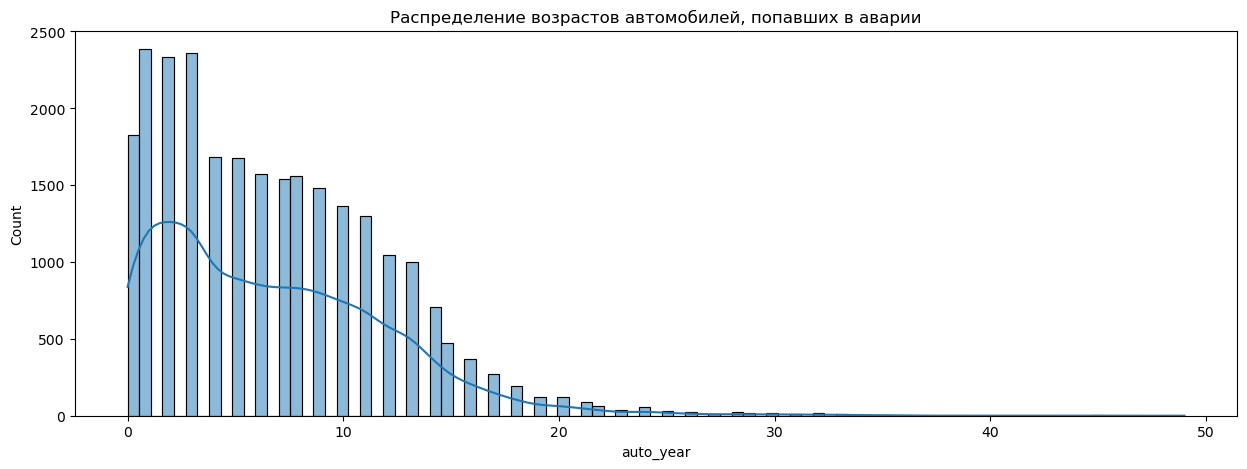

In [34]:
# Построим гистограмму распределения ВОЗРАСТОВ автомобилей, попавших в аварии
plt.figure(figsize = (15,5))
plt.title('Распределение возрастов автомобилей, попавших в аварии')
sns.histplot(df_AY['auto_year'], kde = True)
plt.show()

По гистограмме видно, что основная масса аварий на автомобилях младше 15 лет...
Присутствует большой хвост в графике, значит есть выбросы, избавимся от них

In [35]:
q1 = df_AY['auto_year'].quantile(0.25)
q3 = df_AY['auto_year'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr
print(f"Выбросами будут считаться все возрасты автомобилей, значения которых находится за пределами интервала [{lower_bound}, {upper_bound}]")

Выбросами будут считаться все возрасты автомобилей, значения которых находится за пределами интервала [-10.0, 22.0]


In [36]:
# Формируем новый датасет без выбросов
df_AYnew = df_AY[((df_AY['auto_year'] >= lower_bound) & (df_AY['auto_year'] <= upper_bound))]
df_AYnew.shape

(25528, 17)

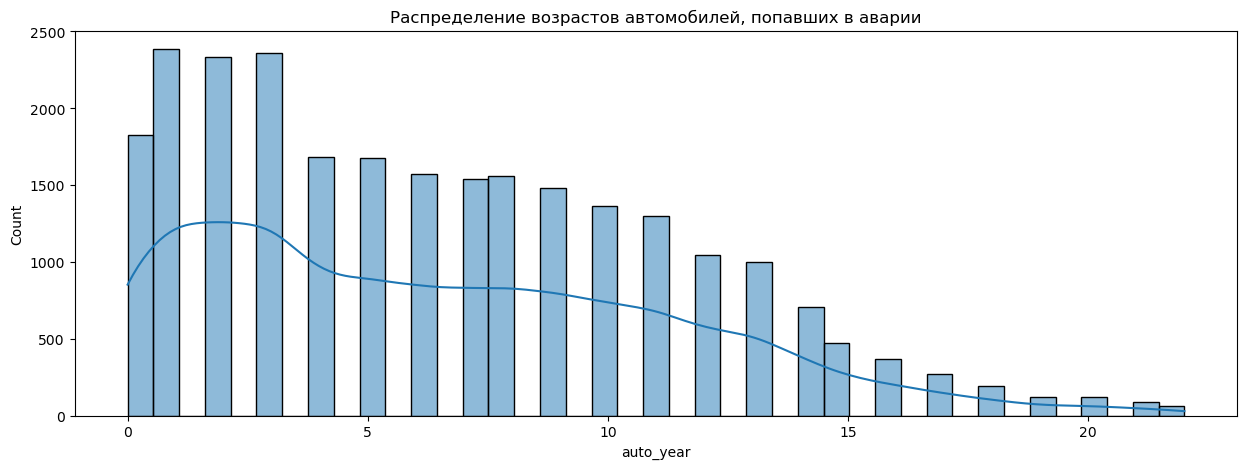

In [37]:
# Построим гистограмму распределения ВОЗРАСТОВ автомобилей (менее 22 лет), попавших в аварии
plt.figure(figsize = (15,5))
plt.title('Распределение возрастов автомобилей, попавших в аварии')
sns.histplot(df_AYnew['auto_year'], kde = True)
plt.show()

In [38]:
# Группа 1 - датасет с возрастом авто от 0 до 10 лет (включительно)
df_AYnew_10 = df_AYnew[(df_AYnew['auto_year'] <= 10)]
df_AYnew_10.shape

(19785, 17)

In [39]:
# Группа 2 - датасет с возрастом авто от 10 до 20 лет (включительно)
df_AYnew_20 = df_AYnew[(df_AYnew['auto_year'] > 10)&(df_AYnew['auto_year'] <= 20)]
df_AYnew_20.shape

(5591, 17)

In [40]:
# Поссмотрим количество смертельных ДТП
df_AYnew[df_AYnew['dead1'] == 1].shape

(1128, 17)

In [41]:
# Поссмотрим количество умерших на авто, возрастом от 0 до 10 лет (включительно)
df_AYnew_10[df_AYnew_10['dead1'] == 1].shape

(799, 17)

In [42]:
# Поссмотрим количество умерших на авто, возрастом от 10 до 20 лет (включительно)
df_AYnew_20[df_AYnew_20['dead1'] == 1].shape

(319, 17)

In [43]:
# Рассчитаем конверсии общую и по группам
print('Конверсия общая:', df_AYnew[df_AYnew['dead'] == 'dead'].shape[0] / df_AYnew.shape[0])            # 1128/25528
print('Конверсия группы 1:', df_AYnew_10[df_AYnew_10['dead'] == 'dead'].shape[0] / df_AYnew_10.shape[0])   # 799/19785
print('Конверсия группы 2:', df_AYnew_20[df_AYnew_20['dead'] == 'dead'].shape[0] / df_AYnew_20.shape[0])   # 319/5591

Конверсия общая: 0.04418677530554685
Конверсия группы 1: 0.04038412939095274
Конверсия группы 2: 0.057055982829547484


In [44]:
# Проведем тест на значимость разницы между группами
stats.ttest_ind(df_AYnew_10['dead1'], df_AYnew_20['dead1'])

TtestResult(statistic=-5.36647420145184, pvalue=8.099427224258302e-08, df=25374.0)

##### Нулевая гипотеза: равенство средней конверсии в обеих группах.
##### p-значение < 5%, поэтому отвергаем эту гипотезу. Конверсия в группе 1 (авто от 0 до 10 лет) и конверсия в группе 2 (авто от 10 до 20 лет) отличаются. Конверсия в группе 2 больше.
##### С ПРАКТИЧЕСКОЙ ТОЧКИ ЗРЕНИЯ: при увеличении количества автомобилей с возрастом более 10 лет, количество аварий со смертельным исходом становится больше, чем становилось бы при увеличении количества автомобилей с возрастом менее 10 лет.
##### ВЫВОД: БЕЗОПАСНЕЕ ЕЗДИТЬ НА БОЛЕЕ "СВЕЖИХ" АВТОМОБИЛЯХ!!!

#### 3) Попробуем рассмотреть какие-нибудь интересности: определим зависимость смертности и срабатывания подушек безопасности

In [45]:
# Сформируем датасеты со столбцами Смертность и срабатыванию подушек безопасности
df_dead = df['dead']
df_airbag = df['deploy']

# Построим таблицу сопряженности
df_dead_airbag = pd.crosstab(df_dead, df_airbag)
df_dead_airbag

deploy,0,1
dead,,
alive,16391,8410
dead,797,359


In [46]:
# Используем тест Пирсона (хи-квадрат) для проверки взаимосвязи двух категориальных переменных
stats.chi2_contingency(df_dead_airbag)

Chi2ContingencyResult(statistic=3.8967233244950834, pvalue=0.048380379963154814, dof=1, expected_freq=array([[16422.52910583,  8378.47089417],
       [  765.47089417,   390.52910583]]))

##### Нулевая гипотеза - между двумя категориальными переменными зависимости нет.
##### р-значение чуть ниже 5%, следовательно, данные противоречат нулевой гипотезе и мы можем ее отвергнуть.
##### Между смертностью в ДТП и раскрытием подушек безопасности есть зависимость
##### С ПРАКТИЧЕСКОЙ ТОЧКИ ЗРЕНИЯ: Раскрытие подушек безопасности при авариях снижает получение тяжелых травм, несовместимых с жизнью.
##### ВЫВОД: ПРИ ПОКУПКЕ АВТОМОБИЛЯ ВСЕ-ТАКИ НЕОБХОДИМО РАССМАТРИВАТЬ КОМПЛЕКТАЦИИ С ПОДУШКАМИ БЕЗОПАСНОСТИ.

#### 4) Попробуем рассмотреть какие-нибудь интересности: зависимость расчетной скорости удара и серъезности полученных травм

In [47]:
# Создадим датасет без строк с Серьезностью аварий 5 и 6, там немного ненужных и непонятных данных.
df_S = df[(df['injSeverity'] < 5)]
df_S.shape

(25824, 17)

In [48]:
# Сформируем датасеты со столбцами Расчетная скорость удара и серъезность полученных травм
df_S_speed = df_S['dvcat']
df_S_severity = df_S['injSeverity']

# Построим таблицу сопряженности
df_speed_severity = pd.crosstab(df_S_speed, df_S_severity)
df_speed_severity

injSeverity,0.0,1.0,2.0,3.0,4.0
dvcat,,,,,
1-9km/h,363,144,65,90,4
10-24,4517,3365,1852,2803,108
25-39,1364,1639,1616,3198,273
40-54,185,352,548,1532,324
55+,33,80,143,831,395


In [49]:
# Используем тест Пирсона (хи-квадрат) для проверки взаимосвязи двух категориальных переменных
stats.chi2_contingency(df_speed_severity)

Chi2ContingencyResult(statistic=5995.536968520207, pvalue=0.0, dof=16, expected_freq=array([[ 166.65473978,  143.90799257,  108.93680297,  218.02834572,
          28.47211896],
       [3164.18796468, 2732.30715613, 2068.32713755, 4139.59223978,
         540.58550186],
       [2024.37964684, 1748.07156134, 1323.27137546, 2648.42239777,
         345.85501859],
       [ 735.93331784,  635.4855948 ,  481.05576208,  962.79484201,
         125.73048327],
       [ 370.84433086,  320.22769517,  242.40892193,  485.16217472,
          63.35687732]]))

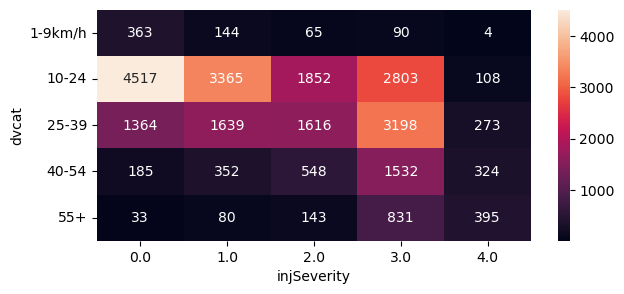

In [50]:
# Визуализируем итоги на тепловой карте
plt.figure(figsize = (7,3))
sns.heatmap(df_speed_severity, annot = True, fmt='.0f')
plt.show()

##### Нулевая гипотеза - между двумя категориальными переменными зависимости нет.
##### р-значение существенно ниже 5%, следовательно, данные противоречат нулевой гипотезе и мы можем ее отвергнуть.
##### Между скоростью удара и серъезностью травм есть значимая зависимость.
##### С ПРАКТИЧЕСКОЙ ТОЧКИ ЗРЕНИЯ: чем на большей скорости водитель попал в аварию, тем более сильные травмы он может получить, в том числе и травмы, несовместимые с жизнью.
##### ВЫВОД: ТИШЕ ЕДЕШЬ - ДАЛЬШЕ БУДЕШЬ!!!!!!!!!

________________________________________________________________________________________________________________________________

### VIII На основе проведенных наблюдений о взаимосвязи между переменными сформулируем задачу классификации или регрессии, которая может иметь практическую ценность

#### Для дальнейшей работы с задачей классификации и составлением прогнозов возьмем датасет с фильтром по ДТП только при ФРОНТАЛЬНОМ УДАРЕ по ВОДИТЕЛЯМ (назовем датасет df_class и дальше будем работать с ним)

In [51]:
# Сформируем датасет с ДТП только при фронтальном ударе
df_class = df[(df['frontal'] == 1)&(df['occRole'] == 'driver')]
df_class.shape

(13353, 17)

##### Минздрав нас всегда предупреждает... А что, если нас будет предупреждать ИИ в автомобилях. Предположим: недалекое будущее, в каждом автомобиле имеется ИИ для контроля и управления автомобилем. Туда забиваются все данные о водителе и автомобиле, а также текущей информации в процессе поездки. На приборной панели на экране есть значки предупреждения, и одно из них: СМЕРТЬ!.. красным шрифтом. Данный знак будет выходить при наличии некоторых параметров (данные о машине и водителе), при которых ИИ будет понимать, что водителю при аварии грозит смерть. ИИ также будет сигнализировать о том, что нужно предпринять действия или мероприятия, уменьшающие данные риски (уменьшающие вероятность смерти при ДТП). Соответственно водитель, увидев такой сигнал, должен принять соответствующие меры: уменьшить скорость, пристегнуть ремень, или вообще в силу своего возраста, пола и комплектации автомобиля - купить новый укомплектованный различными защитами автомобиль.

In [52]:
# За целевой столбец возьмем столбец Смертьность
df_class['target'] = np.where(df_class['dead'] == 'dead', 1, 0)
df_class.head()

,dvcat,weight,dead,airbag,seatbelt,frontal,sex,ageOFocc,yearacc,yearVeh,abcat,occRole,deploy,injSeverity,caseid,dead1,auto_year,target
0,25-39,25.069,alive,none,belted,1,f,26,1997,1990.0,unavail,driver,0,3.0,2:3:1,0,7.0,0
1,10-24,25.069,alive,airbag,belted,1,f,72,1997,1995.0,deploy,driver,1,1.0,2:3:2,0,2.0,0
2,10-24,32.379,alive,none,none,1,f,69,1997,1988.0,unavail,driver,0,4.0,2:5:1,0,9.0,0
3,25-39,495.444,alive,airbag,belted,1,f,53,1997,1995.0,deploy,driver,1,1.0,2:10:1,0,2.0,0
4,25-39,25.069,alive,none,belted,1,f,32,1997,1988.0,unavail,driver,0,3.0,2:11:1,0,9.0,0


________________________________________________________________________________________________________________________________

### IX Подготовим переменные для работы

##### Столбцы Вес (weight), год аварии (yearacc), Наличие подушки и срабатывание (abcat), факт срабатывания подушки (deploy), серъезность аварии (injSeverity), ИД (caseid) использовать не будем по причине их нелогичности и ненужности в нашей сформулированной задаче

In [53]:
# Категориальные переменные
cat_vars = ['dvcat', 'airbag', 'seatbelt', 'sex']
# Количественные переменные
num_vars = ['ageOFocc', 'yearVeh']
# Целевая переменная
target_var = ['target']

In [54]:
df_class[cat_vars] = df_class[cat_vars].astype(str)

#### Переведем категориальные переменные в числовой формат

In [55]:
# Закодируем категориальные переменные числами
X = pd.get_dummies(df_class[cat_vars], drop_first = True, dtype = int)
X.head()

,dvcat_10-24,dvcat_25-39,dvcat_40-54,dvcat_55+,airbag_none,seatbelt_none,sex_m
0,0,1,0,0,1,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,1,1,0
3,0,1,0,0,0,0,0
4,0,1,0,0,1,0,0


#### Нормализуем количественные переменные (в шкалу от 0 до 1)

In [56]:
scaler = MinMaxScaler()
scaler.fit(df_class[num_vars])

MinMaxScaler()

In [57]:
X[num_vars] = scaler.transform(df_class[num_vars])
X.head()

,dvcat_10-24,dvcat_25-39,dvcat_40-54,dvcat_55+,airbag_none,seatbelt_none,sex_m,ageOFocc,yearVeh
0,0,1,0,0,1,0,0,0.140845,0.74
1,1,0,0,0,0,0,0,0.788732,0.84
2,1,0,0,0,1,1,0,0.746479,0.70
3,0,1,0,0,0,0,0,0.521127,0.84
4,0,1,0,0,1,0,0,0.225352,0.70


#### Теперь переменные готовы для обучения!!!

________________________________________________________________________________________________________________________________

### X Разделим датасет на обучающую (60%) и тестовую (40%) выборки. Далее тестовую выборку разделим пополам (20% и 20%)

##### 1) Первую половину будем использовать для оценки качества модели. Предполагаем, что здесь мы знаем наблюдаемые значения таргета, и можем сравнивать их с предсказаниями.
##### 2) Вторую половину будем использовать для построения прогнозов. Предполагаем, что здесь значения таргета нам неизвестны – как в практической ситуации использования моделей прогнозирования.

In [58]:
y = df_class[target_var].values
# Разделяем переменные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)

# Разделим тестовую выборку пополам
X_test1, X_test2, y_test1, y_test2 = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

________________________________________________________________________________________________________________________________

### XI Обучим различные модели, проведем оценку их качества на первой половине тестовой выборки

##### Модели, которые дали крайне низкий результата или никакого, в данный блокнот не включены. Это Модель SVM

#### 1) Модель KNeighborsClassifier

In [59]:
# Обучаем модель на обучающей части данных с помощью модели классификации KNN
neigh = KNeighborsClassifier(n_neighbors = 3)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [60]:
# Предсказываем для тестовой части значение целевой переменной
y_pred = neigh.predict(X_test1)

In [61]:
# Количество реальных смертельных исходов
np.sum(y_test1)

85

In [62]:
# Количество предсказанных смертельных исходов
np.sum(y_pred)

40

In [63]:
# Сравниваем предсказанные значения с реальными значениями
pd.DataFrame(confusion_matrix(y_test1, y_pred), index = ['True 0', 'True 1'], columns = ['Pred 0', 'Pred 1'])

,Pred 0,Pred 1
True 0,2552,34
True 1,79,6


##### Из 85 реальных смертельных исходов, предсказаны только 6. Из 40 предсказанных смертельных исходов, реально было 6 смертельных случаев.

In [64]:
# Рассмотрим метрики качества модели
print('Precision', precision_score(y_test1, y_pred))
print('Recall', recall_score(y_test1, y_pred))

Precision 0.15
Recall 0.07058823529411765


##### Качество модели - очень низкое. Процент смертей, которые модель корректно обозначает, составялет 15%, а процент реальных смертей, которые модель способна поймать - 7%.

##### Пробуем подобрать значение гиперпараметра

In [65]:
for i in range(3, 30, 2):
    neigh = KNeighborsClassifier(n_neighbors = i)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test1)
    print('Neigbors:', i, 
          'Precision:', np.round(precision_score(y_test1, y_pred),3), 
          'Recall', np.round(recall_score(y_test1, y_pred),3)
         )

Neigbors: 3 Precision: 0.15 Recall 0.071
Neigbors: 5 Precision: 0.207 Recall 0.071
Neigbors: 7 Precision: 0.2 Recall 0.059
Neigbors: 9 Precision: 0.25 Recall 0.059
Neigbors: 11 Precision: 0.167 Recall 0.024
Neigbors: 13 Precision: 0.2 Recall 0.024
Neigbors: 15 Precision: 0.0 Recall 0.0
Neigbors: 17 Precision: 0.333 Recall 0.012
Neigbors: 19 Precision: 0.5 Recall 0.012
Neigbors: 21 Precision: 0.0 Recall 0.0
Neigbors: 23 Precision: 0.0 Recall 0.0
Neigbors: 25 Precision: 0.0 Recall 0.0
Neigbors: 27 Precision: 0.0 Recall 0.0
Neigbors: 29 Precision: 0.0 Recall 0.0


##### При значении параметра 9 - получаются оптимальные значения: процент смертей, которые модель корректно обозначает, составялет 25%, а процент реальных смертей, которые модель способна поймать - 5,9%.
##### При значении параметра 19 - процент смертей, которые модель корректно обозначает, составялет 50%, а процент реальных смертей, которые модель способна поймать - всего 1,2%.

#### 2) Модель Decision tree

In [66]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test1)
print(
    'Precision:', np.round(precision_score(y_test1, y_pred),3), 
    'Recall', np.round(recall_score(y_test1, y_pred),3)
)

Precision: 0.125 Recall 0.141


##### В модели Decision tree - процент смертей, которые модель корректно обозначает, составялет 12,5%, а процент реальных смертей, которые модель способна поймать - 14,1%. (цифры иногда чуточку меняются при перезагрузке блокнота)

#### 3) Модель Benchmark - модель случайного предсказания

In [67]:
prob = np.mean(y_test1)
from scipy.stats import bernoulli
y_pred = bernoulli.rvs(prob, size = len(y_test1))
print(
    'Precision:', np.round(precision_score(y_test1, y_pred),3), 
    'Recall', np.round(recall_score(y_test1, y_pred),3)
)

Precision: 0.024 Recall 0.024


##### В модели Benchmark - процент смертей, которые модель корректно обозначает, составялет 2,4%, а процент реальных смертей, которые модель способна поймать - 2,4%. (цифры иногда чуточку меняются при перезагрузке блокнота)

#### 4) Модель Random Forest

In [68]:
from sklearn.ensemble import RandomForestClassifier
for i in range(1, 30, 2):
    rf_clf = RandomForestClassifier(max_depth=i, random_state=42)
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    print('Depth:', i, 
          'Precision:', np.round(precision_score(y_test, y_pred),3), 
          'Recall', np.round(recall_score(y_test, y_pred),3)
         )

Depth: 1 Precision: 0.0 Recall 0.0
Depth: 3 Precision: 0.0 Recall 0.0
Depth: 5 Precision: 0.667 Recall 0.021
Depth: 7 Precision: 0.412 Recall 0.037
Depth: 9 Precision: 0.357 Recall 0.053
Depth: 11 Precision: 0.289 Recall 0.069
Depth: 13 Precision: 0.219 Recall 0.085
Depth: 15 Precision: 0.256 Recall 0.117
Depth: 17 Precision: 0.228 Recall 0.122
Depth: 19 Precision: 0.223 Recall 0.122
Depth: 21 Precision: 0.228 Recall 0.122
Depth: 23 Precision: 0.238 Recall 0.128
Depth: 25 Precision: 0.238 Recall 0.128
Depth: 27 Precision: 0.238 Recall 0.128
Depth: 29 Precision: 0.238 Recall 0.128


##### При значении параметра 5 - процент смертей, которые модель корректно обозначает, составялет 66,7%, а процент реальных смертей, которых модель способна поймать - 2,1%.
##### При значении параметра 23 - получаются оптимальные значения: процент смертей, которые модель корректно обозначает, составялет 23,8%, а процент реальных смертей, которых модель способна поймать - всего 12,8%.

________________________________________________________________________________________________________________________________

### XII Выберем модель и набор переменных, которые дают наиболее удовлетворительное качество

#### По моему мнению в нашем анализе важна метрика Recall - это процент реальных смертей, которые модель способна поймать (чем выше это число, тем лучше), тем более вероятно, что человеку на экране будут высвечиваться реальные предсказания-предупреждения. И нам практически не важна метрика Precision, так как если ИИ спрогнозирует фейковую смерть на экране, и человек произведет мероприятия по уменьшению вероятности смерти, то в этом нет ничего плохого, наоборот даже лучше, так сказать с запасом))).

##### 1) Из расчетов, проделанных выше, метрика Recall выше у модели Decision tree - 14,1%.
##### 2) Проделал аналогичные расчеты в другом файлике, убрав одну количествунную переменную "yearVeh" (год выпуска авто). Метрика Recall выше у модели Decision tree - 12,9%.
##### 3) Проделал аналогичные расчеты в другом файлике, переместив переменную "yearVeh" (год выпуска авто) из блока количественных и блок категориальных. Метрика Recall выше у модели Decision tree - 17,6%.

#### В итоге получаем, что качество моделей низкое при текущих переменных, возможно необходим другой набор переменных, возможно больше количественных, чем категориальных.
#### Но даже с учетом небольших скачущих значений модели Decision tree, мы выбираем именно её, так как она показывает наилучшие результаты из пробного файла.
#### Ниже воспроизведем модель Decision tree из пробного файла, у которой метрика Recall - 17,6% (предварительно переместив переменную "yearVeh" (год выпуска авто) из блока количественных и блок категориальных)

In [69]:
# Дублирую весь код, который был в пробном файле, начиная с выбора блоков переменных, деления на выборки, и заканчивая моделью Decision tree
cat_vars = ['dvcat', 'airbag', 'seatbelt', 'sex', 'yearVeh']     # Вот тут ключевое различие, столбец yearVeh перемещен в cat_vars!!!
num_vars = ['ageOFocc']
df_class[cat_vars] = df_class[cat_vars].astype(str)
X = pd.get_dummies(df_class[cat_vars], drop_first = True, dtype = int)
scaler = MinMaxScaler()
scaler.fit(df_class[num_vars])
X[num_vars] = scaler.transform(df_class[num_vars])
y = df_class['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)
X_test1, X_test2, y_test1, y_test2 = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test1)
print(
    'Precision:', np.round(precision_score(y_test1, y_pred),3), 
    'Recall', np.round(recall_score(y_test1, y_pred),3)
)

Precision: 0.163 Recall 0.176


##### В модели Decision tree - процент смертей, которые модель корректно обозначает, составялет 16,3%, а процент реальных смертей, которые модель способна поймать - 17,6%.

________________________________________________________________________________________________________________________________

### XIII На основе второй половины тестовой выборки сделаем предсказание целевой переменной. На основе предсказаний сделаем рекомендации для потенциальных пользователей нашего анализа.

In [70]:
# Формируем прогнозный массив
X_predskazanie = df_class.loc[X_test2.index, cat_vars + num_vars + target_var]
X_predskazanie.shape

(2671, 7)

In [71]:
# Делаем предсказание
y_predskazanie = tree_clf.predict(X_test2)

In [72]:
# Добавляем столбец с предсказаниями в наш прогнозный массив
X_predskazanie['dead_pred'] = y_predskazanie
X_predskazanie 

,dvcat,airbag,seatbelt,sex,yearVeh,ageOFocc,target,dead_pred
12181,10-24,airbag,none,f,1997.0,60,0,0
4605,10-24,airbag,belted,f,1997.0,39,0,0
15599,10-24,airbag,belted,m,1999.0,43,0,0
17328,25-39,none,none,f,1993.0,34,0,0
14840,25-39,none,belted,m,1987.0,20,0,0
...,...,...,...,...,...,...,...,...
13540,10-24,airbag,belted,f,1997.0,29,0,0
19959,25-39,airbag,belted,f,1999.0,57,0,0
17098,10-24,airbag,belted,f,2000.0,53,0,0
15131,10-24,airbag,belted,m,1996.0,23,0,0


In [73]:
# Смотрим количество предсказанных смертельных исходов в 2671 автокатастроф
X_predskazanie['dead_pred'].sum()

100

In [74]:
# Выберем только ДТП со смертельными исходами
X_predskazanie1 = X_predskazanie[X_predskazanie['dead_pred'] == 1]
X_predskazanie1.head()

,dvcat,airbag,seatbelt,sex,yearVeh,ageOFocc,target,dead_pred
5715,25-39,none,none,m,1993.0,20,0,1
25609,55+,none,none,m,1980.0,71,1,1
15663,55+,none,none,f,1993.0,24,0,1
17846,10-24,airbag,none,f,1998.0,21,0,1
593,40-54,none,none,m,1991.0,70,0,1


##### Для составления рекомендаций необходимо привести примерную статистику по каждому столбцу.
##### Проссматривая данные каждого столбца с помощью метода value_counts() можно дать следующие рекомендации водителям:
##### 1) Одна из основных причин смертельного ДТП при фронтальном столкновении - это конечно же скорость! Количество предсказанных смертельных исходов увеличивается с увеличением скоростного режима транспорта. Скоростной режим необходимо выбирать с умом!
##### 2) Наличие подушек безопасности и наличие ремней безопасности не всегда играют решающую роль для ухода от смертельного ДТП. С ними конечно вероятнее остаться живыми, но не всегда они помогают. Поэтому однозначно необходимо ими укомплектовывать автомобиль.
##### 3) Кто бы что ни говорил, но женщины ездят аккуратнее и с ними меньше смертельных ДТП. Поэтому не стоит бояться быть пассажиром, когда за рулем женщина.
##### 4) Ну и конечно возраст водителя. Молодые водители находятся в большей зоне риска попасть в смертельное ДТП, поэтому не стоит переоценивать своих возможностей пока опыта не набрались...

### НА ЭТОМ Я ЗАКОНЧИЛ СВОЙ АНАЛИЗ ДАННЫХ.
### СПАСИБО ЗА ОБУЧЕНИЕ!!!
### БЫЛО ООООЧЕНЬ СЛОЖНО, НО ООООЧЕНЬ ИНТЕРЕСНО!!!